# Jupyter notebook example

### R code with Sea Lamprey data

USGS Scientists often produce one-off analyses that become part of larger "stories". 
However, the data and code from these oneoff products often cannot be used for other projects unless the users is an expert in the subject field. 
Interactive products such as Jupyter notebooks could be used to highlight key findings and help others intereste in these products find them and learn how to use them. 

For this example, we examine eDNA data generated as part of sea lamprey monitoring research. 
The data come from [ScienceBase](https://www.sciencebase.gov/catalog/item/59b6cc06e4b08b1644ddf8b3), where the original source code was published as well source [code](https://www.sciencebase.gov/catalog/item/5bace929e4b08583a5d10c46).
For this demonstration, the source code has been adapted to highlight a key finding using the [Tidyverse](https://www.tidyverse.org/). 

First, we load the required libraries. 

In [44]:
library(tidyverse)
library(lme4)
library(scales)


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor



Next, we read in our data from Science Base. 
We print the data to peak at it.

In [19]:
url <- "https://www.sciencebase.gov/catalog/file/get/59b6cc06e4b08b1644ddf8b3?f=__disk__f7%2F19%2F08%2Ff719084d841c0419e3a7f9a747c156406e32a85b"
dat <- read.csv(url) %>% as_tibble()
dat %>% head()
dat %>% dim()

Sample,Fluor,Copies,Inhibited
<fct>,<fct>,<dbl>,<fct>
200L-2A,FAM,1336000,NO
200L-2B,FAM,1099000,NO
200L-2C,FAM,1229000,NO
200L-3A,FAM,1827000,NO
200L-3B,FAM,1758000,NO
200L-3C,FAM,1543000,NO


[1] 352   4

The data requires some cleanup before we can plot and model it. 

In [27]:
dat <-
    dat %>%
    filter(Fluor == "FAM" & grepl("L-", Sample)) %>%
    mutate(Stock_level = gsub("(\\d+L)-(\\d[A-Z])", "\\1", Sample), 
           Sample_ID   = gsub("(\\d+L)-(\\d)([A-Z])", "\\2", Sample),
           Subsample_ID = gsub("(\\d+L)-(\\d)([A-Z])", "\\3", Sample))
dat %>% head()

Sample,Fluor,Copies,Inhibited,Stock_level,Sample_ID,Subsample_ID
<fct>,<fct>,<dbl>,<fct>,<chr>,<chr>,<chr>
200L-2A,FAM,1336000,NO,200L,2,A
200L-2B,FAM,1099000,NO,200L,2,B
200L-2C,FAM,1229000,NO,200L,2,C
200L-3A,FAM,1827000,NO,200L,3,A
200L-3B,FAM,1758000,NO,200L,3,B
200L-3C,FAM,1543000,NO,200L,3,C


We then need to aggregate the data by taking the mean of each sample. 

In [37]:
dat_sample <-
    dat %>%
    mutate(Copies = ifelse(is.na(Copies), 0, Copies),
           Stock_level = factor(Stock_level, levels = c("0L", "2L", "20L", "200L"))) %>%
    group_by(Stock_level, Sample_ID) %>%
    summarize(Copies = mean(Copies)) 
dat_sample

Stock_level,Sample_ID,Copies
<fct>,<chr>,<dbl>
0L,1,1.288267e+00
0L,2,8.593167e-01
0L,3,2.632833e+00
2L,1,4.237750e+03
2L,2,9.374333e+03
2L,3,2.176500e+03
20L,1,2.037250e+05
20L,2,1.248875e+05
20L,3,7.472750e+04


Next, we plot the data using `ggplot()`.
This shows how eDNA copy numbers increases based upon stocking.

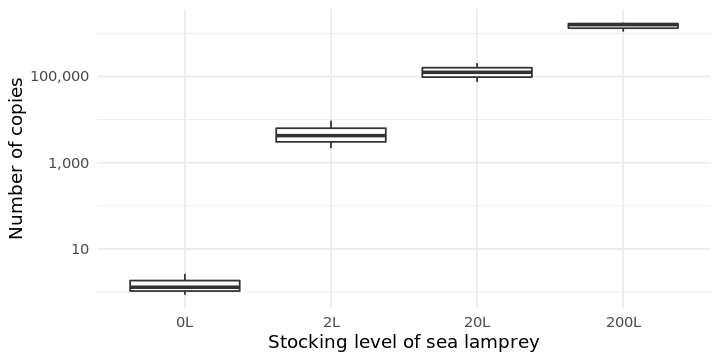

In [46]:
options(repr.plot.width=6, repr.plot.height=3)
ggplot(data = dat_sample, aes(x = Stock_level, y = Copies)) +
    geom_boxplot() +
    scale_y_log10(label=comma) +
    theme_minimal() +
    ylab("Number of copies") +
    xlab("Stocking level of sea lamprey")

We can also use a mixed-effect regression to confirm these findings. 

In [52]:
eDNA_model <- lmer(log10(Copies) ~ Stock_level + (1|Sample_ID), dat_sample)
summary(eDNA_model)

boundary (singular) fit: see ?isSingular


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: log10(Copies) ~ Stock_level + (1 | Sample_ID)
   Data: dat_sample

REML criterion at convergence: 3.9

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.30976 -0.63085 -0.03185  0.49920  1.38836 

Random effects:
 Groups    Name        Variance Std.Dev.
 Sample_ID (Intercept) 0.00000  0.000   
 Residual              0.05525  0.235   
Number of obs: 12, groups:  Sample_ID, 3

Fixed effects:
                Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)       0.1549     0.1357 8.0000   1.141    0.287    
Stock_level2L     3.4908     0.1919 8.0000  18.189 8.58e-08 ***
Stock_level20L    4.9382     0.1919 8.0000  25.731 5.58e-09 ***
Stock_level200L   6.0068     0.1919 8.0000  31.299 1.18e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) Stc_2L St_20L
Stock_lvl2L -0.707              
Stck_lvl20